<a href="https://colab.research.google.com/github/rogercost/fire-guardrails/blob/main/Guardrails_Simplified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Guardrail-Based Withdrawals

This notebook attempts to replicate the guardrail-based withdrawal strategy described here: https://youtu.be/-_UtH2WCt2E

This approach is meant to allow retirees to spend more by adapting to market conditions, allowing larger withdrawals when the market is up, and reducing them when the market is down, in order to maximize the "area under the curve" of lifetime spending.

## Step 1: Market Data Prep

We'll load Shiller's file that he publishes on his website: https://shillerdata.com/

This contains a historical time series of stock and bond market performance going back to 1871, which forms the basis for our analysis.


In [1]:
import os
import time
import requests
import numba as nb
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from pathlib import Path
from datetime import datetime, timedelta
from scipy.interpolate import RegularGridInterpolator
from multiprocessing import Pool, cpu_count
from itertools import product
from tqdm import tqdm

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy import stats

In [2]:
def parse_shiller_date(series):
    """
    Convert Shiller-style yyyy.mm strings/floats into proper datetimes.
    Examples:
      1950.01 -> 1950-01-01
      1950.1  -> 1950-10-01
      1950.11 -> 1950-11-01
    """
    s = series.astype(str).str.strip()

    def _norm(val):
        year, month_part = val.split(".", 1)
        # Special case: .1 means October (Excel dropped the zero)
        if month_part == "1":
            month = "10"
        else:
            month = month_part.zfill(2)
        return f"{year}-{month}-01"

    return pd.to_datetime(s.map(_norm), format="%Y-%m-%d")

In [3]:
local_path = Path(os.path.join("tempdir", "shillerdata.xls"))

# This is the link found in https://shillerdata.com/
url = "https://img1.wsimg.com/blobby/go/e5e77e0b-59d1-44d9-ab25-4763ac982e53/downloads/9becfac9-1778-47a6-b40e-299d8c616706/ie_data.xls"

# Check if file exists and is less than 30 days old
def needs_update(path, days=30):
    if not path.exists():
        return True
    age_days = (time.time() - path.stat().st_mtime) / (24 * 3600)
    return age_days > days

# Download if missing or outdated
if needs_update(local_path):
    local_path.parent.mkdir(parents=True, exist_ok=True)
    r = requests.get(url)
    r.raise_for_status()
    with open(local_path, "wb") as f:
        f.write(r.content)

# Read multi-line headers (rows 4–7) and collapse them
headers_raw = pd.read_excel(local_path, sheet_name="Data", skiprows=4, nrows=4, header=None)
headers = (
    headers_raw.fillna("")
    .astype(str)
    .agg(" ".join)           # join rows into one string
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)  # clean spaces
)

# Read the actual data (starting row 8)
df = pd.read_excel(local_path, sheet_name="Data", skiprows=8)
df.columns = headers

# Drop the last row which contains footnotes
df = df.iloc[:-1].reset_index(drop=True)

# TEMPORARY: Also drop the second to last row which as of 20251004 is a duplicate
df = df.iloc[:-1].reset_index(drop=True)

df["Date"] = parse_shiller_date(df["Date"])

df.tail()

,Date,S&P Comp. P,Dividend D,Earnings E,Consumer Price Index CPI,Date Fraction,Long Interest Rate GS10,Real Price,Real Dividend,Real Total Return Price,...,Earnings Ratio P/E10 or CAPE,,Earnings Ratio TR P/E10 or TR CAPE,,Excess CAPE Yield,Monthly Total Bond Returns,Real Total Bond Returns,10 Year Annualized Stock Real Return,10 Year Annualized Bonds Real Return,Real 10 Year Excess Annualized Returns
1850,2025-04-01,5369.495714,76.546867,219.026667,320.795,2025.291667,4.28,5413.320220,77.171624,3.641872e+06,...,32.621270,NaN,35.015341,NaN,0.018767,0.992343,39.643654,NaN,NaN,NaN
1851,2025-05-01,5810.919524,76.948434,221.363333,321.465,2025.375000,4.42,5846.136807,77.414782,3.937395e+06,...,35.076007,NaN,37.636543,NaN,0.014912,1.006896,39.258095,NaN,NaN,NaN
1852,2025-06-01,6029.9515,77.350000,223.700000,322.561,2025.458333,4.38,6045.883451,77.554369,4.076277e+06,...,36.108975,NaN,38.730193,NaN,0.014487,1.002847,39.394513,NaN,NaN,NaN
1853,2025-07-01,6296.498182,NaN,NaN,323.048,2025.541667,4.39,6303.617235,NaN,4.250048e+06,...,37.469882,NaN,40.132464,NaN,0.013530,1.014158,39.447119,NaN,NaN,NaN
1854,2025-08-01,6408.949524,NaN,NaN,323.2915,2025.625000,4.26,6411.363103,NaN,4.322692e+06,...,38.031442,NaN,40.708786,NaN,0.014659,1.005976,39.975485,NaN,NaN,NaN


## Step 2. Defining a Goal Seek Approach

Using the data in this dataframe, we can run multiple simulation paths at a fixed withdrawal rate and calculate a probability of success (how many of those paths end up with >0 ending balances).

However, the fundamental computation we need in order to calculate the guardrail is the inverse of this. Given a desired success rate, we need to work out the withdrawal rate that results in it. That allows us to find the upper and lower guardrail portfolio values.

We'll use a binary-search algorithm to try different withdrawal rates within a range, cutting the range in half until we get our desired success rate.

In [4]:
@nb.jit(nopython=True)
def test_all_periods(portfolio_returns, num_months, initial_value, monthly_withdrawal):
    """
    Run all paths of a given length that exist in the supplied portfolio_reurns array,
    capturing the success or failure of each path, and returning the proportion of successes.

    We're running this in a tight loop so we'll Numba-compile it for ultra-fast simulation.
    """
    num_periods = len(portfolio_returns) - num_months + 1
    successes = 0

    for start_idx in range(num_periods):
        value = initial_value

        for i in range(num_months):
            value = value * portfolio_returns[start_idx + i] - monthly_withdrawal
            if value <= 0:
                break

        if value > 0:
            successes += 1

    return successes / num_periods


def calculate_success_rate(df, withdrawal_rate, num_months, stock_pct=0.75,
                           analysis_start_date='1871-01-01', analysis_end_date=None, initial_value=1_000_000):
    """
    Calculate the success rate for a given withdrawal rate.
    Numba-accelerated version. Should be 500x+ faster than brute force.
    First call will be slower due to compilation, subsequent calls will be blazing fast.
    That way we can use it iteratively in a guess-and-check loop.
    """
    # Prepare data
    analysis_start = pd.to_datetime(analysis_start_date)
    df_filtered = df[df['Date'] >= analysis_start]

    if analysis_end_date is not None:
        analysis_end = pd.to_datetime(analysis_end_date)
        df_filtered = df_filtered[df_filtered['Date'] <= analysis_end]

    # Calculate portfolio returns
    stock_prices = df_filtered['Real Total Return Price'].values
    bond_prices = df_filtered['Real Total Bond Returns'].values

    stock_returns = np.ones(len(stock_prices))
    stock_returns[1:] = stock_prices[1:] / stock_prices[:-1]

    bond_returns = np.ones(len(bond_prices))
    bond_returns[1:] = bond_prices[1:] / bond_prices[:-1]

    portfolio_returns = stock_pct * stock_returns + (1 - stock_pct) * bond_returns
    monthly_withdrawal = initial_value * withdrawal_rate / 12

    # Call the compiled function
    return test_all_periods(portfolio_returns, num_months, initial_value, monthly_withdrawal)


def get_wr_for_fixed_success_rate(df, desired_success_rate, num_months,
                                  analysis_start_date='1871-01-01',
                                  analysis_end_date=None,
                                  initial_value=1_000_000, stock_pct=0.75,
                                  tolerance=0.001, max_iterations=50,
                                  verbose=False):
    """
    Compute the annual withdrawal rate such that a historical simulation over periods of the desired length
    yields the desired success rate.

    Parameters
    ----------
    df : pd.DataFrame
        The main dataframe with market data
    desired_success_rate : float
        The target chance of underspending (e.g., 0.90 for 90%),
        the percent of simulation paths that should have ending portfolio values > 0.
    num_months : int
        The size of the time window of the historical simulation paths to run
        (corresponds to the remaining time in retirement).
    analysis_start_date : str, optional
        The start date from which we should begin running simulation paths,
        if we do not want to start at the very beginning.
    initial_value : float, optional
        Initial portfolio value (default 1,000,000)
    stock_pct : float, optional
        Percentage of portfolio in stocks (default 0.75)
    tolerance : float, optional
        Tolerance for success rate matching (default 0.001 = 0.1%)
    max_iterations : int, optional
        Maximum iterations for binary search (default 50)
    verbose : bool, optional
        Print progress (default False)

    Returns
    -------
    dict
        Dictionary containing:
        - 'withdrawal_rate': The annual withdrawal rate that achieves the target success rate
        - 'actual_success_rate': The actual success rate achieved
        - 'num_simulations': Number of simulation paths run
        - 'iterations': Number of binary search iterations performed
    """

    # Edge case: we can't goal seek if the algo is one ended
    if desired_success_rate > 1.0 - tolerance:
        if verbose:
            print(f"Edge case: reducing desired success rate from {desired_success_rate} to effective algo ceiling of {1.0 - tolerance}")
        desired_success_rate = 1.0 - tolerance

    if desired_success_rate < tolerance:
        if verbose:
            print(f"Edge case: increasing desired success rate from {desired_success_rate} to effective algo floor of {tolerance}")
        desired_success_rate = tolerance

    # Convert analysis_start_date to datetime
    analysis_start = pd.to_datetime(analysis_start_date)

    # Filter dataframe to only include dates from analysis_start_date onwards
    df_filtered = df[df['Date'] >= analysis_start].copy()

    # Optional: propose an end date. If we're running a historical simulation of this method, we cannot allow access to future data.
    if analysis_end_date is not None:
        analysis_end = pd.to_datetime(analysis_end_date)
        df_filtered = df_filtered[df_filtered['Date'] <= analysis_end]

    # Get all possible starting dates for simulation periods
    max_end_idx = len(df_filtered) - num_months
    if max_end_idx <= 0:
        raise ValueError(f"Not enough data for {num_months} month simulations starting from {analysis_start_date}")

    num_paths = max_end_idx + 1

    # Binary search for the withdrawal rate
    low_rate = 0  # 0.0% annual withdrawal rate
    high_rate = 0.20  # 20% annual withdrawal rate

    iteration = 0
    best_rate = None
    best_success_rate = None

    if verbose:
        print(f"Searching for withdrawal rate with {desired_success_rate:.1%} success rate...")

    while iteration < max_iterations:
        mid_rate = (low_rate + high_rate) / 2

        current_success_rate = calculate_success_rate(df, mid_rate, num_months, stock_pct,
                                                      analysis_start_date, analysis_end_date, initial_value)

        # Check if we're within tolerance
        if abs(current_success_rate - desired_success_rate) <= tolerance:
            best_rate = mid_rate
            best_success_rate = current_success_rate
            if verbose:
                print(f"Converged! Found withdrawal rate within tolerance.")
            break

        # Adjust search bounds
        # If success rate is too high, we can withdraw more
        if current_success_rate > desired_success_rate:
            low_rate = mid_rate
            if verbose:
                print(f"Success rate at {mid_rate} is too high ({current_success_rate:.3f} > {desired_success_rate:.3f}), "
                      f"increasing withdrawal rate range to [{low_rate:.4f}, {high_rate:.4f}]")
        else:
            # If success rate is too low, we need to withdraw less
            high_rate = mid_rate
            if verbose:
                print(f"Success rate at {mid_rate} is too low ({current_success_rate:.3f} < {desired_success_rate:.3f}), "
                      f"decreasing withdrawal rate range to [{low_rate:.4f}, {high_rate:.4f}]")

        best_rate = mid_rate
        best_success_rate = current_success_rate
        iteration += 1

    if iteration >= max_iterations:
        if verbose:
            print(f"Reached maximum iterations ({max_iterations}). Returning best found rate.")

    # Return results
    return {
        'withdrawal_rate': best_rate,
        'actual_success_rate': best_success_rate,
        'num_simulations': num_paths,
        'iterations': iteration + 1
    }

## Test the goal-seek algorithm

Pick a desired success rate and period length, as well as optional start and end dates for the entire analysis, and the desired asset allocation.

Run it verbose so we can see how it arrives at the answer of which withdrawal rate yields the success rate.

In [18]:
# Example: Find withdrawal rate for 100% success rate over 30-year periods
result = get_wr_for_fixed_success_rate(
    df=df,
    desired_success_rate=0.75,
    num_months=600,
    analysis_start_date='1871-01-01',
    analysis_end_date='1968-04-01',
    initial_value=1_000_000,
    stock_pct=0.75,
    verbose=True
)
print(f"Annual withdrawal rate for desired success rate: {result['withdrawal_rate']:.4f} ({result['withdrawal_rate']*100:.2f}%)")
print(f"Actual success rate achieved: {result['actual_success_rate']:.4f} ({result['actual_success_rate']*100:.2f}%)")
print(f"Number of simulation paths: {result['num_simulations']}")
print(f"Binary search iterations: {result['iterations']}")

Searching for withdrawal rate with 75.0% success rate...
Success rate at 0.1 is too low (0.007 < 0.750), decreasing withdrawal rate range to [0.0000, 0.1000]
Success rate at 0.05 is too low (0.576 < 0.750), decreasing withdrawal rate range to [0.0000, 0.0500]
Success rate at 0.025 is too high (1.000 > 0.750), increasing withdrawal rate range to [0.0250, 0.0500]
Success rate at 0.037500000000000006 is too high (0.988 > 0.750), increasing withdrawal rate range to [0.0375, 0.0500]
Success rate at 0.043750000000000004 is too high (0.798 > 0.750), increasing withdrawal rate range to [0.0438, 0.0500]
Success rate at 0.046875 is too low (0.699 < 0.750), decreasing withdrawal rate range to [0.0438, 0.0469]
Success rate at 0.045312500000000006 is too high (0.757 > 0.750), increasing withdrawal rate range to [0.0453, 0.0469]
Success rate at 0.04609375 is too low (0.731 < 0.750), decreasing withdrawal rate range to [0.0453, 0.0461]
Success rate at 0.045703125000000004 is too low (0.745 < 0.750), 

## Step 3: Implement the Guardrail Strategy

We'll define a function that applies the guardrail strategy as it would have been run during a defined historical period of time. Say, if we had retired in 1962 and had a 50 year time horizon - what would our portfolio value and spending have looked like over the next 50 years if we had used the guardrail strategy.

Very roughly, the approach is that we'll first calculate the starting withdrawal rate based on the desired "target" success rate (using the above algo). Then every month after that, we'll do the following:

* Calculate the upper and lower guardrail portfolio values based on that withdrawal rate
* If our current portfolio is > upper or < lower, reset the withdrawal rate to match the original target success rate (with the new portfolio value and # of months to retirement)

In [29]:
def get_guardrail_withdrawals(df, start_date, end_date,
                              analysis_start_date='1871-01-01',
                              initial_value=1_000_000,
                              stock_pct=0.75,
                              target_success_rate=0.90,
                              upper_guardrail_success=1.00,
                              lower_guardrail_success=0.75,
                              upper_adjustment_fraction=1.0,
                              lower_adjustment_fraction=0.1,
                              adjustment_threshold=0.05,
                              verbose=False):
    """
    Creates a dataframe of withdrawals that follow an adaptive guardrail strategy.

    The strategy:
    1. Each month, calculate the withdrawal rate that gives target_success_rate
    2. Calculate portfolio values that would make current spending have upper/lower success rates
    3. If portfolio hits guardrails, adjust spending
    4. Only implement adjustment if it exceeds threshold (to avoid constant small changes)

    Returns
    -------
    pd.DataFrame
        A dataframe with Date, Withdrawal, and diagnostic columns.
    """
    # Filter to analysis period
    mask = (df["Date"] >= pd.to_datetime(start_date)) & (df["Date"] <= pd.to_datetime(end_date))
    subset = df[mask].copy().reset_index(drop=True)

    # Pre-compute portfolio returns for the entire historical period (for speed)
    all_stock_prices = df['Real Total Return Price'].values
    all_bond_prices = df['Real Total Bond Returns'].values

    stock_returns = np.ones(len(all_stock_prices))
    stock_returns[1:] = all_stock_prices[1:] / all_stock_prices[:-1]

    bond_returns = np.ones(len(all_bond_prices))
    bond_returns[1:] = all_bond_prices[1:] / all_bond_prices[:-1]

    portfolio_returns = stock_pct * stock_returns + (1 - stock_pct) * bond_returns

    # Initialize results storage
    results = []

    # Get the initial withdrawal rate based on the target success rate
    #
    initial_wr = get_wr_for_fixed_success_rate(df=df,
                                               desired_success_rate=target_success_rate,
                                               num_months=len(subset),
                                               analysis_start_date=analysis_start_date,
                                               analysis_end_date=start_date,  # We're starting this in the past!
                                               initial_value=initial_value,
                                               stock_pct=stock_pct,
                                               tolerance=0.001,
                                               max_iterations=50,
                                               verbose=False)['withdrawal_rate']

    if verbose:
        print(f"Initial withdrawal rate: {(initial_wr * 100):.2f}%")

    # State variables
    current_portfolio_value = initial_value
    previous_monthly_spending = initial_value * initial_wr / 12
    previous_spending_date = pd.to_datetime(start_date)

    # Get CPI data for inflation adjustments
    cpi_data = df[['Date', 'Consumer Price Index CPI']].copy()

    for i, row in subset.iterrows():
        current_date = row['Date']
        months_remaining = len(subset) - i

        # Calculate 3 withdrawal rates: the target, and the upper and lower guardrail, based on the current portfolio value and months remaining
        #
        target_wr = get_wr_for_fixed_success_rate(df=df,
                                                  desired_success_rate=target_success_rate,
                                                  num_months=months_remaining,
                                                  analysis_start_date=analysis_start_date,
                                                  analysis_end_date=current_date,
                                                  initial_value=current_portfolio_value,
                                                  stock_pct=stock_pct,
                                                  tolerance=0.001,
                                                  max_iterations=50,
                                                  verbose=False)['withdrawal_rate']

        upper_wr = get_wr_for_fixed_success_rate(df=df,
                                                 desired_success_rate=upper_guardrail_success,
                                                 num_months=months_remaining,
                                                 analysis_start_date=analysis_start_date,
                                                 analysis_end_date=current_date,
                                                 initial_value=current_portfolio_value,
                                                 stock_pct=stock_pct,
                                                 tolerance=0.001,
                                                 max_iterations=50,
                                                 verbose=False)['withdrawal_rate']

        lower_wr = get_wr_for_fixed_success_rate(df=df,
                                                 desired_success_rate=lower_guardrail_success,
                                                 num_months=months_remaining,
                                                 analysis_start_date=analysis_start_date,
                                                 analysis_end_date=current_date,
                                                 initial_value=current_portfolio_value,
                                                 stock_pct=stock_pct,
                                                 tolerance=0.001,
                                                 max_iterations=50,
                                                 verbose=False)['withdrawal_rate']

        # The guardrail portfolio values are the values that would result in the **current** withdrawal amount
        # representing a probability of success equal to each guardrail's probability.
        #
        upper_guardrail_value = previous_monthly_spending / upper_wr * 12
        lower_guardrail_value = previous_monthly_spending / lower_wr * 12


        if verbose and i % 12 == 0:
            print(f"Processing {current_date.strftime('%Y-%m')}, portfolio=${current_portfolio_value:,.0f}, months_remaining={months_remaining}")

        # Step 3: Check if we hit guardrails
        hit_upper = current_portfolio_value >= upper_guardrail_value
        hit_lower = current_portfolio_value <= lower_guardrail_value

        # Step 4: Calculate proposed spending adjustment
        if hit_upper:
            # Re-establish the target spending based on the current portfolio value
            target_monthly_spending = current_portfolio_value * target_wr / 12

            # Adjust spending upward (target - previous will be positive)
            new_proposed_spending = previous_monthly_spending + upper_adjustment_fraction * (target_monthly_spending - previous_monthly_spending)
            guardrail_hit = "UPPER"

        elif hit_lower:
            # Re-establish the target spending based on the current portfolio value
            target_monthly_spending = current_portfolio_value * target_wr / 12

            # Adjust spending downward (target - previous will be negative)
            new_proposed_spending = previous_monthly_spending + lower_adjustment_fraction * (target_monthly_spending - previous_monthly_spending)
            guardrail_hit = "LOWER"

        else:
            new_proposed_spending = previous_monthly_spending
            guardrail_hit = "NONE"

        # Step 6: Only adjust if the new dollar amount differs from the previous dollar amount by more than the configured threshold.
        #
        percent_change = abs(new_proposed_spending - previous_monthly_spending) / previous_monthly_spending

        if percent_change > adjustment_threshold:
            # Make the adjustment
            actual_monthly_spending = new_proposed_spending
            previous_spending_date = current_date  # Reset inflation baseline
            adjustment_made = True
        else:
            # Keep previous spending (inflation adjusted)
            actual_monthly_spending = previous_monthly_spending
            adjustment_made = False

        # Store results
        results.append({
            'Date': current_date,
            'Withdrawal': actual_monthly_spending,
            'Portfolio_Value': current_portfolio_value,
            'Target_WR': target_wr,
            'Upper_Guardrail': upper_guardrail_value,
            'Lower_Guardrail': lower_guardrail_value,
            'Guardrail_Hit': guardrail_hit,
            'Percent_Change': percent_change,
            'Adjustment_Made': adjustment_made
        })

        # Update portfolio value for next month
        # Apply withdrawal
        current_portfolio_value -= actual_monthly_spending

        # Apply market returns (if not at end)
        if i < len(subset) - 1:
            # Find the index in the full dataset
            full_idx = df[df['Date'] == current_date].index[0]
            month_return = portfolio_returns[full_idx + 1] if full_idx + 1 < len(portfolio_returns) else 1.0
            current_portfolio_value *= month_return

        # Update state
        previous_monthly_spending = actual_monthly_spending

        # Check for bankruptcy
        if current_portfolio_value <= 0:
            if verbose:
                print(f"Portfolio depleted at {current_date}")
            break

    return pd.DataFrame(results)

## Test the guardrail strategy

Let's run for the period of 1968-2018, a famously challenging historical period for the hypothetical early retiree - first stagflation, then the '87 crash, dotcom crash and financial crisis. Will we survive?

In [22]:
def plot_guardrail_portfolio(df, figsize=(14, 8)):
    """
    Plot portfolio value with guardrail bounds and withdrawals over time.

    Parameters
    ----------
    df : pd.DataFrame
        Results from get_guardrail_withdrawals with columns:
        Date, Withdrawal, Portfolio_Value, Upper_Guardrail, Lower_Guardrail, etc.
    figsize : tuple
        Figure size (width, height)
    """
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=figsize, sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # --- Plot 1: Portfolio values with guardrails ---
    # Plot the guardrail bounds as shaded area
    ax1.fill_between(df["Date"],
                     df["Lower_Guardrail"],
                     df["Upper_Guardrail"],
                     alpha=0.2, color='gray',
                     label='Guardrail Zone')

    # Plot the guardrail lines
    ax1.plot(df["Date"], df["Upper_Guardrail"],
            linestyle='--', color='green', alpha=0.7, linewidth=1,
            label='Upper Guardrail (100% success)')
    ax1.plot(df["Date"], df["Lower_Guardrail"],
            linestyle='--', color='red', alpha=0.7, linewidth=1,
            label='Lower Guardrail (75% success)')

    # Plot actual portfolio value
    ax1.plot(df["Date"], df["Portfolio_Value"],
            label="Portfolio Value", linewidth=2.5, color='blue')

    # Mark points where adjustments were made
    adjustment_points = df[df['Adjustment_Made'] == True]
    if not adjustment_points.empty:
        ax1.scatter(adjustment_points["Date"],
                   adjustment_points["Portfolio_Value"],
                   color='orange', s=50, zorder=5,
                   label=f'Spending Adjustments ({len(adjustment_points)})')

    # Mark guardrail hits with different markers
    upper_hits = df[df['Guardrail_Hit'] == 'UPPER']
    lower_hits = df[df['Guardrail_Hit'] == 'LOWER']

    if not upper_hits.empty:
        ax1.scatter(upper_hits["Date"], upper_hits["Portfolio_Value"],
                   marker='^', color='green', s=30, zorder=4, alpha=0.7,
                   label=f'Upper Guardrail Hits ({len(upper_hits)})')

    if not lower_hits.empty:
        ax1.scatter(lower_hits["Date"], lower_hits["Portfolio_Value"],
                   marker='v', color='red', s=30, zorder=4, alpha=0.7,
                   label=f'Lower Guardrail Hits ({len(lower_hits)})')

    # Adaptive y-axis ticks
    all_values = pd.concat([df["Portfolio_Value"],
                           df["Upper_Guardrail"],
                           df["Lower_Guardrail"]])
    y_min, y_max = all_values.min(), all_values.max()
    y_range = y_max - y_min

    # Choose appropriate tick spacing
    if y_max > 5_000_000:
        step = 1_000_000
    elif y_max > 1_000_000:
        step = 500_000
    else:
        step = 100_000

    y_min_rounded = np.floor(y_min / step) * step
    y_max_rounded = np.ceil(y_max / step) * step
    y_min_final = min(0, y_min_rounded)
    ax1.set_ylim(y_min_final, y_max_rounded)

    ax1.yaxis.set_major_locator(mtick.MultipleLocator(step))
    ax1.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f"${x/1_000_000:.1f}M")
    )
    ax1.grid(axis="y", which="major", color="lightgray", linestyle="--", linewidth=0.7, alpha=0.5)
    ax1.axhline(0, color="black", linewidth=1, alpha=0.3)
    ax1.set_ylabel("Portfolio Value")
    ax1.set_title("Guardrail Strategy: Portfolio Value and Spending Adjustments")
    ax1.legend(loc='upper right', fontsize=9)

    # Add text box with summary statistics
    final_value = df['Portfolio_Value'].iloc[-1]
    initial_value = df['Portfolio_Value'].iloc[0]
    total_return = (final_value / initial_value - 1) * 100
    avg_withdrawal = df['Withdrawal'].mean()

    stats_text = (f'Final Value: ${final_value:,.0f}\n'
                 f'Total Return: {total_return:.1f}%\n'
                 f'Avg Withdrawal: ${avg_withdrawal:,.0f}/mo')

    ax1.text(0.02, 0.98, stats_text,
            transform=ax1.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=9)

    # --- Plot 2: Withdrawals over time ---
    # Color-code withdrawals based on adjustments
    colors = ['orange' if adj else 'darkblue'
              for adj in df['Adjustment_Made']]

    # Plot as line with markers at adjustment points
    ax2.plot(df["Date"], df["Withdrawal"],
            color='darkblue', alpha=0.7, linewidth=1.5,
            label='Monthly Withdrawal')

    # Highlight adjustment points
    if not adjustment_points.empty:
        ax2.scatter(adjustment_points["Date"],
                   adjustment_points["Withdrawal"],
                   color='orange', s=30, zorder=5,
                   label='Adjusted')

    # Add target spending as reference
    if 'Target_Spending' in df.columns:
        ax2.plot(df["Date"], df["Target_Spending"],
                linestyle=':', color='gray', alpha=0.5, linewidth=1,
                label='Target (90% success)')

    # Y-axis for withdrawals
    w_min, w_max = df["Withdrawal"].min(), df["Withdrawal"].max()
    if 'Target_Spending' in df.columns:
        w_max = max(w_max, df["Target_Spending"].max())
        w_min = min(w_min, df["Target_Spending"].min())

    w_step = 1000  # Fixed 1K spacing
    w_min_final = np.floor(w_min / w_step) * w_step
    w_max_final = np.ceil(w_max / w_step) * w_step
    ax2.set_ylim(w_min_final, w_max_final)

    ax2.yaxis.set_major_locator(mtick.MultipleLocator(w_step))
    ax2.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f"${x/1_000:.0f}K")
    )
    ax2.grid(axis="y", which="major", color="lightgray", linestyle="--", linewidth=0.7, alpha=0.5)
    ax2.set_ylabel("Monthly Withdrawal")
    ax2.legend(loc='upper right', fontsize=9)

    # Add withdrawal statistics
    initial_withdrawal = df['Withdrawal'].iloc[0]
    final_withdrawal = df['Withdrawal'].iloc[-1]
    withdrawal_change = (final_withdrawal / initial_withdrawal - 1) * 100

    withdrawal_stats = (f'Initial: ${initial_withdrawal:,.0f}/mo\n'
                       f'Final: ${final_withdrawal:,.0f}/mo\n'
                       f'Change: {withdrawal_change:+.1f}%')

    ax2.text(0.02, 0.98, withdrawal_stats,
            transform=ax2.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3),
            fontsize=9)

    # Shared x-axis
    ax2.set_xlabel("Date")
    ax2.xaxis.set_major_locator(mdates.YearLocator(5))   # Every 5 years
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    # Rotate x-axis labels if needed
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0, ha='center')

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n" + "="*60)
    print("GUARDRAIL STRATEGY SUMMARY")
    print("="*60)
    print(f"Period: {df['Date'].iloc[0].strftime('%Y-%m')} to {df['Date'].iloc[-1].strftime('%Y-%m')}")
    print(f"Initial Portfolio: ${df['Portfolio_Value'].iloc[0]:,.0f}")
    print(f"Final Portfolio: ${final_value:,.0f}")
    print(f"Total Withdrawals: ${df['Withdrawal'].sum():,.0f}")
    print(f"Number of Spending Adjustments: {df['Adjustment_Made'].sum()}")
    print(f"Upper Guardrail Hits: {(df['Guardrail_Hit'] == 'UPPER').sum()}")
    print(f"Lower Guardrail Hits: {(df['Guardrail_Hit'] == 'LOWER').sum()}")
    print(f"Average Monthly Withdrawal: ${avg_withdrawal:,.0f}")
    print(f"Withdrawal Range: ${df['Withdrawal'].min():,.0f} - ${df['Withdrawal'].max():,.0f}")

Initial withdrawal rate: 4.07%
Processing 1968-04, portfolio=$1,000,000, months_remaining=600
Processing 1969-04, portfolio=$977,007, months_remaining=588
Processing 1970-04, portfolio=$795,505, months_remaining=576
Processing 1971-04, portfolio=$900,218, months_remaining=564
Processing 1972-04, portfolio=$899,211, months_remaining=552
Processing 1973-04, portfolio=$855,560, months_remaining=540
Processing 1974-04, portfolio=$670,037, months_remaining=528
Processing 1975-04, portfolio=$566,396, months_remaining=516
Processing 1976-04, portfolio=$624,179, months_remaining=504
Processing 1977-04, portfolio=$576,269, months_remaining=492
Processing 1978-04, portfolio=$512,199, months_remaining=480
Processing 1979-04, portfolio=$496,405, months_remaining=468
Processing 1980-04, portfolio=$428,248, months_remaining=456
Processing 1981-04, portfolio=$470,185, months_remaining=444
Processing 1982-04, portfolio=$405,672, months_remaining=432
Processing 1983-04, portfolio=$528,255, months_remai

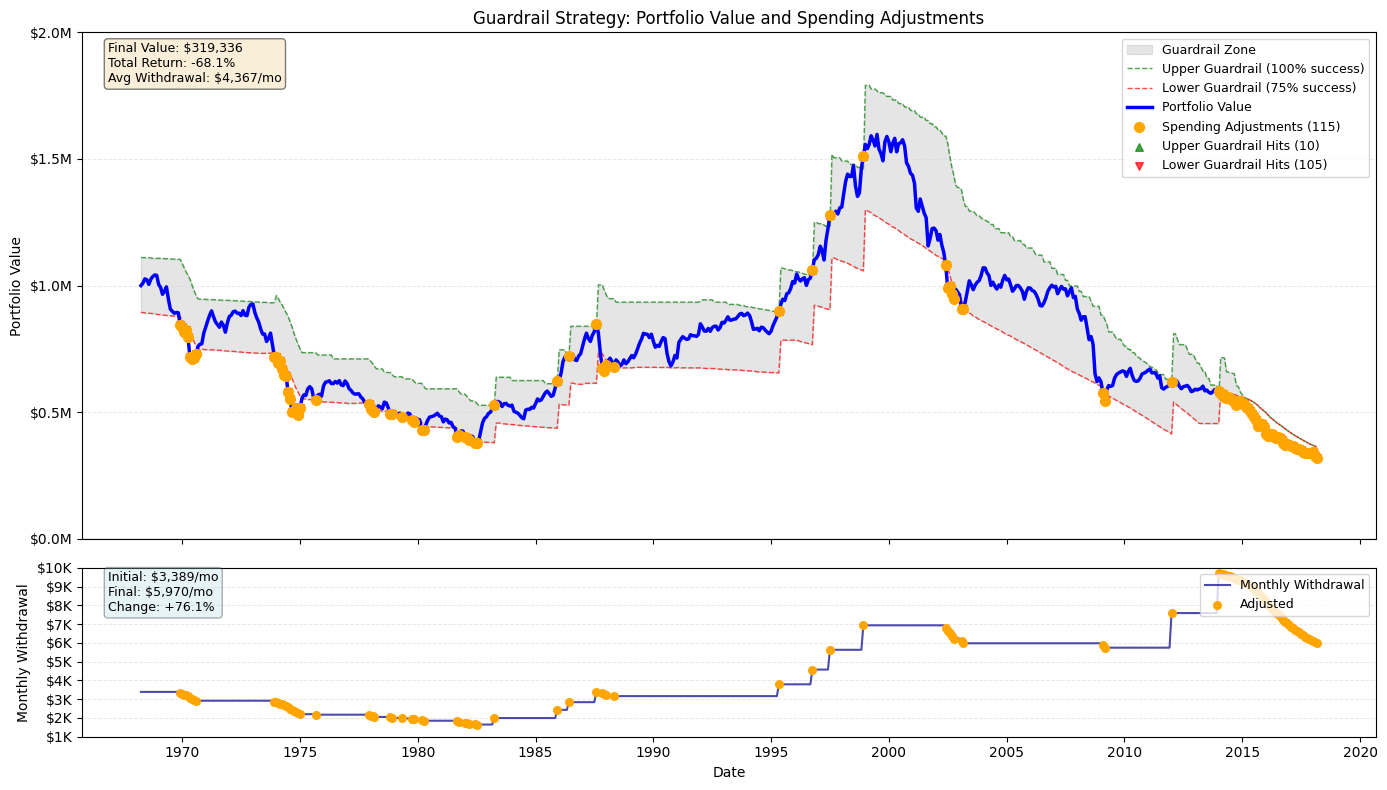


GUARDRAIL STRATEGY SUMMARY
Period: 1968-04 to 2018-03
Initial Portfolio: $1,000,000
Final Portfolio: $319,336
Total Withdrawals: $2,620,301
Number of Spending Adjustments: 115
Upper Guardrail Hits: 10
Lower Guardrail Hits: 105
Average Monthly Withdrawal: $4,367
Withdrawal Range: $1,649 - $9,704


In [34]:
results = get_guardrail_withdrawals(
    df,
    start_date='1968-04-01',
    end_date='2018-03-31',
    initial_value=1_000_000,
    stock_pct=0.75,
    adjustment_threshold=0.00,
    target_success_rate=0.90,
    upper_guardrail_success=1.00,
    lower_guardrail_success=0.75,
    upper_adjustment_fraction=1.0,
    lower_adjustment_fraction=0.1,
    verbose=True
)

# Analyze results
print(f"\nStarting withdrawal: ${results['Withdrawal'].iloc[0]:,.0f}/month")
print(f"Ending withdrawal: ${results['Withdrawal'].iloc[-1]:,.0f}/month")
print(f"Number of adjustments: {results['Adjustment_Made'].sum()}")
print(f"Upper guardrail hits: {(results['Guardrail_Hit'] == 'UPPER').sum()}")
print(f"Lower guardrail hits: {(results['Guardrail_Hit'] == 'LOWER').sum()}")

plot_guardrail_portfolio(results)